In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Simulation of the market

$$S_t = S_{t-1}e^{(\mu - \frac{\sigma^2}{2})\Delta t + \sigma (W_t - W_{t-1})}, \hspace{3mm} S_0 > 0 $$

In [2]:
def simulate_market(mu, sigma, r=0.02, init_price=1, T=252):
    '''
    mu (float):
         Mean returns.
    sigma (float):
        Volatility. 
    init_price (float):
        Initial price of stock, if empty initial price is 100 (must be positive).
    T (int):
        Horizon of investement.
    '''
    dt = 1/T #Discretization

    #Simulate dBrownian with 0 mean and 1 variance
    dW = np.random.normal(0, 1, size=T) * np.sqrt(dt)
    
    stock_prices = np.zeros(T)
    stock_prices[0] = init_price

    #Simulate paths 
    for i in range(1, T):
        drift = (mu - (0.5 * sigma**2)) * dt 
        diffusion = sigma * dW[i]
        stock_prices[i] = stock_prices[i-1] * np.exp(drift + diffusion)
    
    '''
    for i in range(0, T):
        stock_prices[i] = stock_prices[i]*np.exp(-r*i/T)
    '''
    
    return stock_prices

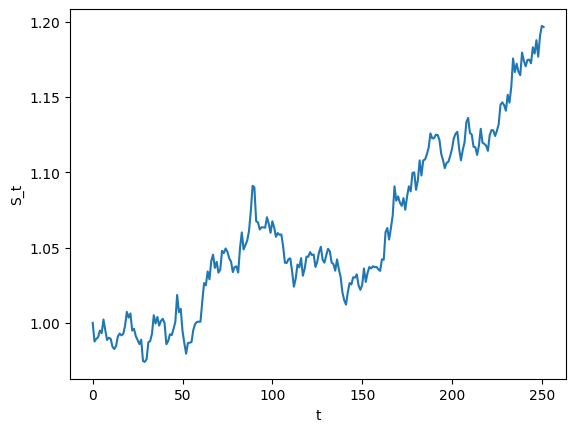

In [3]:
market = simulate_market(0.3, 0.1)
plt.plot(market)
plt.xlabel("t")
plt.ylabel("S_t")
plt.show() 

### EMV Algorithm

#### Value function parametrized by $\theta$
Equation (44) of the paper or (35) of the summary:  
$$ V^\theta (t,x) = (x-w)^2 e^{-\theta_3 (T-t)} + \theta_2 t^2 + \theta_1 t + \theta_0, \hspace{3mm} (t,x) \in [0,T] \times \mathbb{R}$$

We also recall that
$$\dot{V}^\theta(t_i,x_i) = \frac{V^\theta(t_{i+1},x_{i+1}) - V^\theta (t_i,x_i)}{\Delta t}

In [4]:
def V_theta(theta_0, theta_1, theta_2, theta_3, w, T, x, t):
    V = ((x-w)**2) * np.exp(-theta_3*(T-t)) + theta_2*(t**2) + theta_1*t + theta_0
    return V

#### Gradient of $C$ in $\theta$
Equation (47) and (48) of the paper or (39) and (40) of the summary:

$$\frac{\partial C}{\partial \theta_1} = \sum_{(t_i, x_i) \in \mathcal{D}} \left(\dot{V}^\theta(t_i, x_i) - \lambda(\phi_1 + \phi_2 (T-t_i)) \right) \Delta t$$

$$\frac{\partial C}{\partial \theta_2} =  \sum_{(t_i, x_i) \in \mathcal{D}} \left(\dot{V}^{\theta}(t_i, x_i) - \lambda(\phi_1 + \phi_2(T-t_i))\right)(t_{i+1}^2 - t_i^2)$$

In [5]:
def grad_theta(theta_0, theta_1, theta_2, theta_3, w, T, dt, lamb, phi_1, phi_2,
               vec_xi, vec_xi1, vec_ti, vec_ti1):
    
    grad_theta_1 = ((((V_theta(theta_0, theta_1, theta_2, theta_3, w, T, vec_xi1, vec_ti1) - V_theta(theta_0, theta_1, theta_2, theta_3, w, T, vec_xi, vec_ti))/dt) - lamb *(phi_1 + phi_2*(T - vec_ti)))*dt).sum()
    grad_theta_2 = ((((V_theta(theta_0, theta_1, theta_2, theta_3, w, T, vec_xi1, vec_ti1) - V_theta(theta_0, theta_1, theta_2, theta_3, w, T, vec_xi, vec_ti))/dt) - lamb *(phi_1 + phi_2*(T - vec_ti)))*(vec_ti1**2 - vec_ti**2)).sum()
    return grad_theta_1, grad_theta_2

#### Update of $\theta$
Line 7 and 8 of the Algorithm (1)
$$\theta \leftarrow \theta - \eta_\theta \nabla_\theta C(\theta, \phi)$$
$$\theta_0 \leftarrow -\theta_2 T^2 - \theta_1 T - (w-z)^2$$
$$\theta_3 \leftarrow 2\phi_2


In [6]:
def update_theta(theta_0, theta_1, theta_2, theta_3, w, T, dt, lamb, phi_1, phi_2, lr_theta, z,
                vec_xi, vec_xi1, vec_ti, vec_ti1):
    
    grad_theta_1, grad_theta_2 = grad_theta(theta_0, theta_1, theta_2, theta_3, w, T, dt, lamb, phi_1, phi_2, vec_xi, vec_xi1, vec_ti, vec_ti1)

    theta_1 = theta_1 - (lr_theta*grad_theta_1)
    theta_2 = theta_2 - (lr_theta*grad_theta_2)
    theta_0 = -(theta_2 * T**2) - (theta_1 * T) - (w - z)**2
    theta_3 = 2*phi_2
    return theta_0, theta_1, theta_2, theta_3

#### Gradient of C in $\phi$
Equation (49) and (50) of the paper or (41) and (42) of the summary:


$$\frac{\partial C}{\partial \phi_1} = - \lambda  \sum_{(t_i, x_i) \in \mathcal{D}} \left(\dot{V}^\theta (t_i, x_i) - \lambda(\phi_1 + \phi_2(T-t_i)) \right) \Delta t$$

$$\frac{\partial C}{\partial \phi_2} =  \sum_{(t_i, x_i) \in \mathcal{D}} \left(\dot{V}^\theta (t_i, x_i) - \lambda(\phi_1 + \phi_2(T-t_i)) \right) \Delta t \times\left(-\frac{2(x_{i+1} - w)^2 e^{-2\phi_2 (T-t_{i+1})}(T- t_{i+1}) - 2(x_i - w)^2 e^{-2\phi_2 (T-t_i)}(T-t_i)}{\Delta t} - \lambda(T-t_i)\right)$$

In [7]:
def grad_phi(theta_0, theta_1, theta_2, theta_3, w, T, dt, lamb, phi_1, phi_2,
               vec_xi, vec_xi1, vec_ti, vec_ti1):

    grad_phi_1 = -lamb * ((((V_theta(theta_0, theta_1, theta_2, theta_3, w, T, vec_xi1, vec_ti1) - V_theta(theta_0, theta_1, theta_2, theta_3, w, T, vec_xi, vec_ti))/dt) - lamb *(phi_1 + phi_2*(T - vec_ti)))*dt).sum()
    frac1 = 2*((vec_xi1-w)**2)*np.exp(-2*phi_2*(T-vec_ti1))*(T-vec_ti1)
    frac2 = 2*((vec_xi -w)**2)*np.exp(-2*phi_2*(T-vec_ti ))*(T-vec_ti )
    second_term = (-(frac1-frac2)/dt) - lamb*(T-vec_ti)
    grad_phi_2 = (((((V_theta(theta_0, theta_1, theta_2, theta_3, w, T, vec_xi1, vec_ti1) - V_theta(theta_0, theta_1, theta_2, theta_3, w, T, vec_xi, vec_ti))/dt) - lamb *(phi_1 + phi_2*(T - vec_ti)))*dt)*second_term).sum()
    return grad_phi_1, grad_phi_2

#### Update of $\phi$
Line 9 of the Algorithm (1). We ensure that $\phi_2$ is always positive.
$$\phi \leftarrow \phi - \eta_\phi \nabla_\phi C(\theta, \phi)$$

In [8]:
def update_phi(theta_0, theta_1, theta_2, theta_3, w, T, dt, lamb, phi_1, phi_2, lr_phi,
               vec_xi, vec_xi1, vec_ti, vec_ti1):
    
    grad_phi_1, grad_phi_2 = grad_phi(theta_0, theta_1, theta_2, theta_3, w, T, dt, lamb, phi_1, phi_2, vec_xi, vec_xi1, vec_ti, vec_ti1)
    
    phi_1 = phi_1 - (lr_phi*grad_phi_1)
    phi_2 = phi_2 - (lr_phi*grad_phi_2)
    phi_2 = np.max([phi_2, 0.0000000001])
    
    return phi_1, phi_2

#### Value of the portfolio at $t+1$

$$ X_{t+1} = X_t \pm u_t \left(e^{-r\Delta t}\frac{S_{t+1}}{S_t} -1 \right)$$

In [9]:
def next_value_portfolio(ut, St, St1, Xt, r, t, T, dt, mu):
    if mu>r:
        val = Xt + ut*((St1*np.exp(-r*dt)/St)-1)
    else:
        val = Xt - ut*((St1*np.exp(-r*dt)/St)-1)
    return val

#### Exploratory Mean Variance

In [10]:
def EMV(mu, sigma, alpha = 0.05, lr_theta = 0.00005, lr_phi = 0.00005, x_0 = 1, z = 1.4, T = 1, dt=1/252, lamb_0 = 2, M = 20000, N = 10, r=0.02):
    '''
    mu (float):
        Mean returns of the market
    sigma (float):
        Mean std of the market
    alpha (float):
        Learning rate of the Lagrangian
    lr_theta (float):
        Learning rate of theta
    lr_phi (float):
        Learning rate of phi
    x_0 (float):
        Initial value of the portfolio
    z (float):
        Targeted value at time T
    T (int):
        Horizon.
    dt (float):
        Time between two consecutive periods.
    lamb_0 (float):
        Initial value of lambda (exploring parameter). Here, it is constant.
    M (int):
        Number of iterations of algorithm.
    N (int):
        Number of observation for updating Lagrangian
    r (float):
        Interest rate
    '''
    #Initialization of parameters
    phi_1 = -1
    phi_1_pi = phi_1

    theta_1 = 0
    theta_2 = 1
        
    w = z
    theta_0 = -(theta_2 * T**2) - theta_1*T - (w-z)**2
    theta_3 = ((mu-r)/sigma)**2
    phi_2 = theta_3/2
    phi_2_pi = phi_2

    lamb = lamb_0

    tab_xT = []
    tab_sig = []
    tab_phi_1 = []
    tab_phi_2 = []
    tab_w = []
    tab_theta_0 = []
    tab_theta_1 = []
    tab_theta_2 = []
    tab_theta_3 = []

    x_last = []
    
    mean_pi = lambda x : -np.sqrt((2*phi_2_pi)/(lamb*np.pi))*np.exp((2*phi_1_pi -1)/2)*(x-w)
    var_pi = lambda t : (1/(2*np.pi))*np.exp(2*phi_2_pi*(T-t) + 2*phi_1_pi - 1)

    #Starting the algorithm
    for k in range(0, M):
        X_calculated = [x_0]
        t_calculated = [0]
        market = simulate_market(mu, sigma, T=math.ceil(T/dt)+1)
        for i in range(1, math.ceil(T/dt)+1):
            t_i = (i)*dt
            St = market[i-1]
            St1 = market[i]
            Xt = X_calculated[-1]
            ut = np.random.normal(mean_pi(Xt), np.sqrt(var_pi(t_i - dt)))
            Xt1 = next_value_portfolio(ut, St, St1, Xt, r, (t_i-dt), T, dt, mu)

            t_calculated.append(t_i)
            X_calculated.append(Xt1)
            
            vec_xi = np.array(X_calculated[:-1])
            vec_xi1 = np.array(X_calculated[1:])
            vec_ti = np.array(t_calculated[:-1])
            vec_ti1 = np.array(t_calculated[1:])

            theta_0, theta_1, theta_2, theta_3 = update_theta(theta_0, theta_1, theta_2, theta_3, w, T, dt, lamb, phi_1, phi_2, lr_theta, z,
                        vec_xi, vec_xi1, vec_ti, vec_ti1)
            
            phi_1, phi_2 = update_phi(theta_0, theta_1, theta_2, theta_3, w, T, dt, lamb, phi_1, phi_2, lr_phi,
                        vec_xi, vec_xi1, vec_ti, vec_ti1)
            
        phi_1_pi = phi_1
        phi_2_pi = phi_2
        mean_pi = lambda x : -np.sqrt((2*phi_2_pi)/(lamb*np.pi))*np.exp((2*phi_1_pi -1)/2)*(x-w)
        var_pi = lambda t : (1/(2*np.pi))*np.exp(2*phi_2_pi*(T-t) + 2*phi_1_pi - 1)
   
        x_last.append(X_calculated[-1])

        if k%N == 0:
            w = w - alpha*(np.array(x_last).mean() - z)
            x_last = []
        
        tab_xT.append(X_calculated[-1])
        tab_sig.append(np.std(X_calculated))
        tab_phi_1.append(phi_1)
        tab_phi_2.append(phi_2)
        tab_theta_0.append(theta_0)
        tab_theta_1.append(theta_1)
        tab_theta_2.append(theta_2)
        tab_theta_3.append(theta_3)
        tab_w.append(w)

        print(X_calculated[-1])
        
    return {"xT" : tab_xT, "sig" : tab_sig  ,"w" : tab_w, "phi1" : tab_phi_1, "phi2" : tab_phi_2, "theta0" : tab_theta_0, "theta1" : tab_theta_1, "theta2" : tab_theta_2, "theta3" : tab_theta_3}

In [11]:
results = EMV(0.3, 0.1)

1.0280108254261862
1.3183661835958544
1.1730196700682716
1.2181287643667866
0.8563299355812642
0.9940084317564181
1.1700560057423603
1.1095856832813524
1.0029744381940298
1.172004857411068
1.035515476058301
0.9359417438429165
0.9901670078982228
0.9134764094654274
0.9363095851256434
1.0076494590446052
0.9407084100804749
1.021929581967717
0.9692873666536779
1.061004645932341
1.0755304033507815
1.0519622500434072
0.9891220628156127
1.147659860649693
1.1138007891688584
1.1045723247163193
1.008527992927114
0.9660598389340046
1.0647670090057428
0.9308065944840065
1.0455724889493059
1.0305977396236579
0.9866097928698947
0.985652061660932
0.9703344034834405
1.0527230525169253
1.0830244849411605
0.9686592674836678
1.038014924823348
1.0003413562237768
1.0015129378022076
1.0482433491550562
0.9931384156614188
0.9923765782074333
1.1149382797012868
0.9316865492310152
1.118533133318075
0.9532792516300016
0.9676165855612794
1.0257037235867954
0.8921538099514803
0.9978155886766387
1.009060499001451
0.9

#### Results

In [12]:
print(f'Mean Return : {np.array(results["xT"][-2000:]).mean()}')
print(f'Mean Var : {np.array(results["xT"][-2000:]).var()}')
print(f'Sharpe : {(np.array(results["xT"][-2000:]).mean() - 1)/np.array(results["xT"][-2000:]).std()}')

Mean Return : 1.3866257626326302
Mean Var : 0.018161766496431957
Sharpe : 2.868875791668709


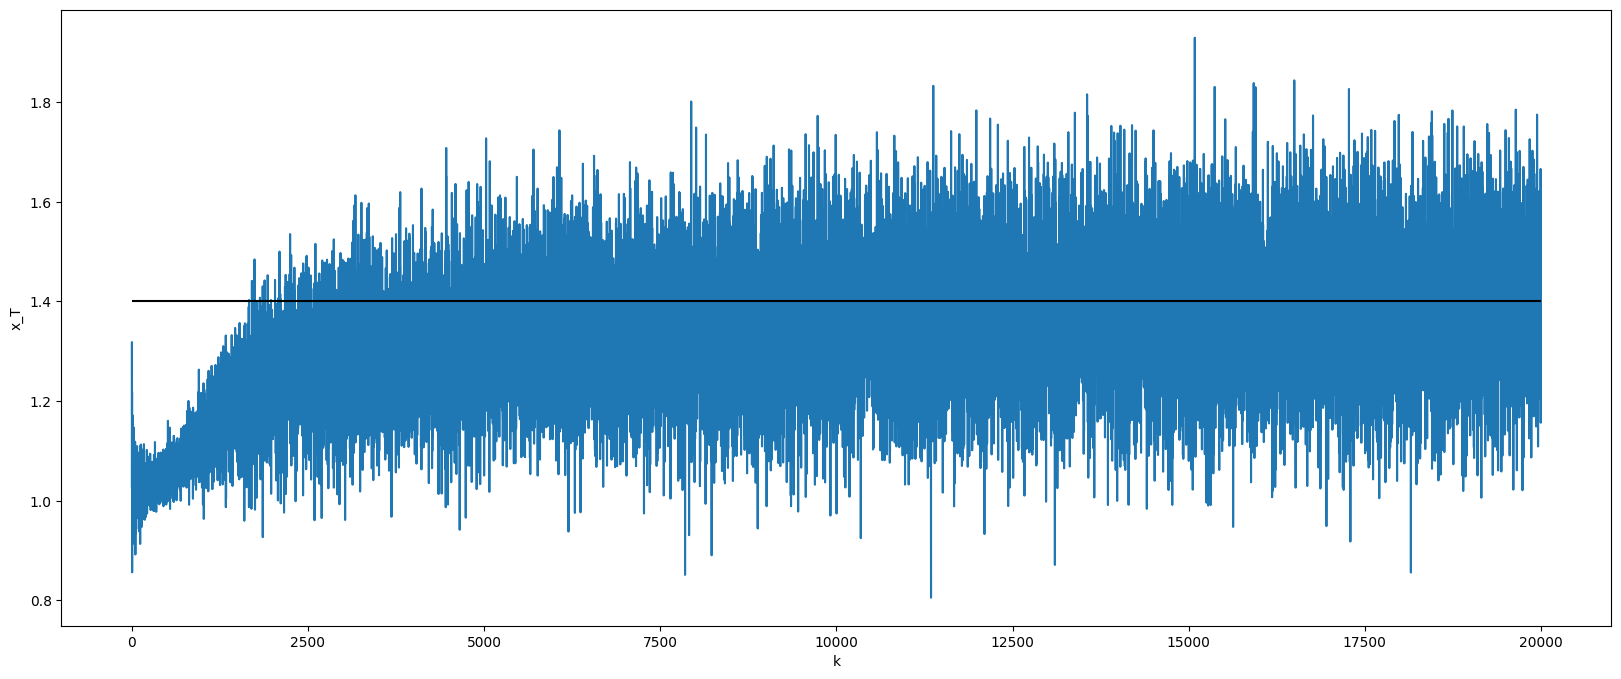

In [13]:
plt.figure(figsize=(20,8))
plt.plot(results["xT"])
plt.hlines(1.4, 0, 20000, color="black")
plt.xlabel("k")
plt.ylabel("x_T")
plt.show()   

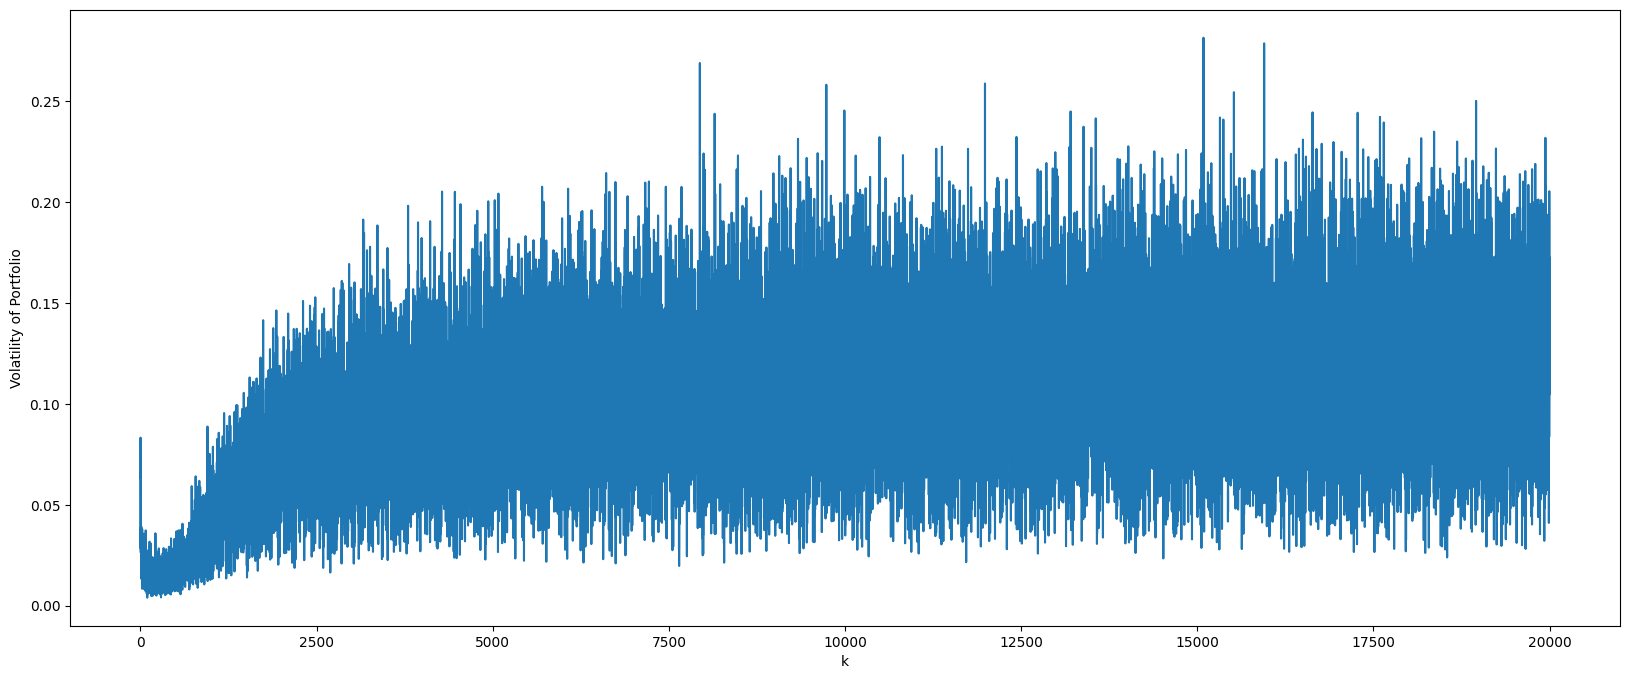

In [14]:
plt.figure(figsize=(20,8))
plt.plot(results["sig"])
plt.xlabel("k")
plt.ylabel("Volatility of Portfolio")
plt.show()

C:\Users\DJADJ\AppData\Local\Temp\ipykernel_14744\539231562.py:4: RuntimeWarning: Mean of empty slice.
  tab.append(np.array(results["xT"][i-50:i]).mean())
c:\Users\DJADJ\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


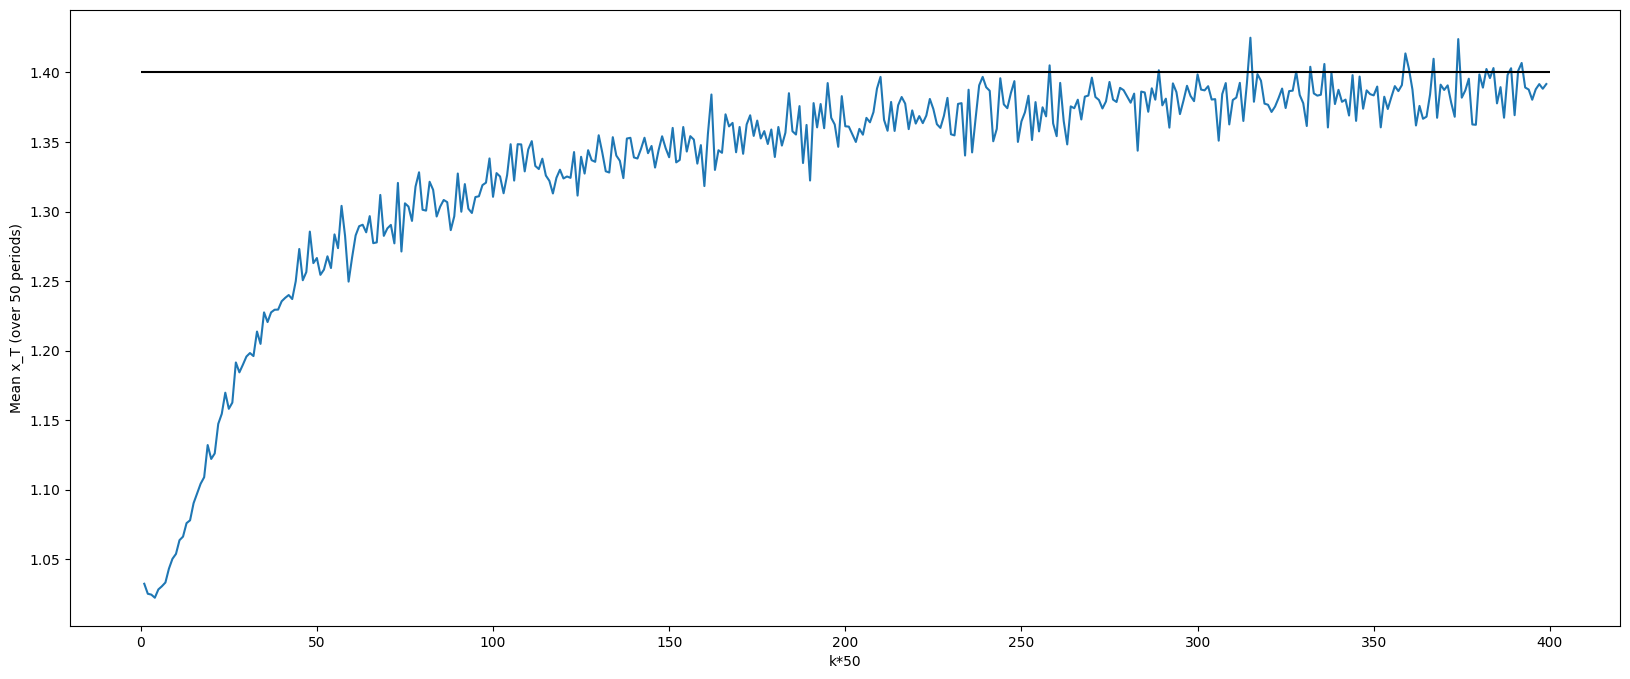

In [15]:
tab = []
for i in range(len(results["xT"][:-2])):
    if i%50 == 0:
        tab.append(np.array(results["xT"][i-50:i]).mean())
plt.figure(figsize=(20,8))
plt.plot(tab)
plt.hlines(1.4, 0, 400, color="black")
plt.xlabel("k*50")
plt.ylabel("Mean x_T (over 50 periods)")
plt.show() 

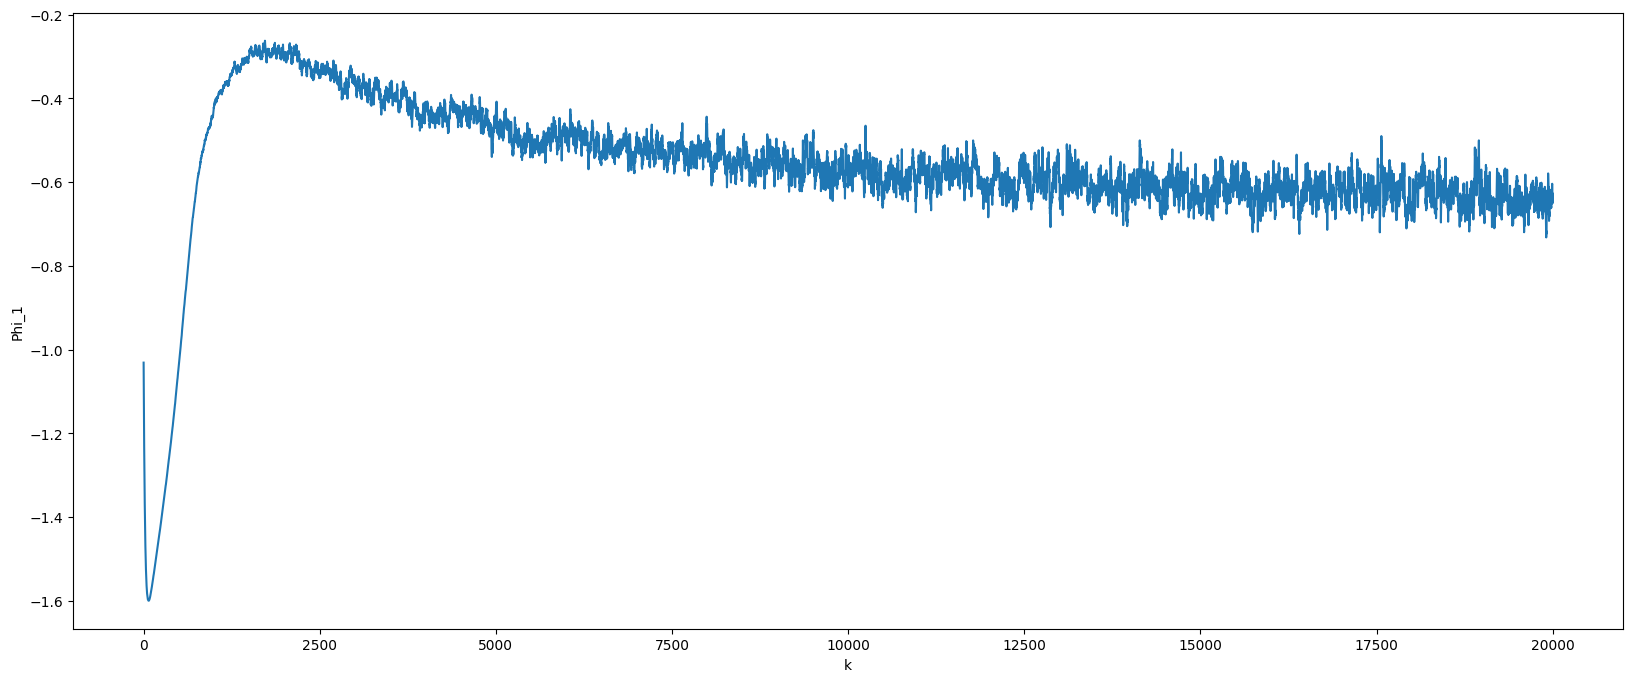

In [16]:
plt.figure(figsize=(20,8))
plt.plot(results["phi1"])
plt.xlabel("k")
plt.ylabel("Phi_1")
plt.show()

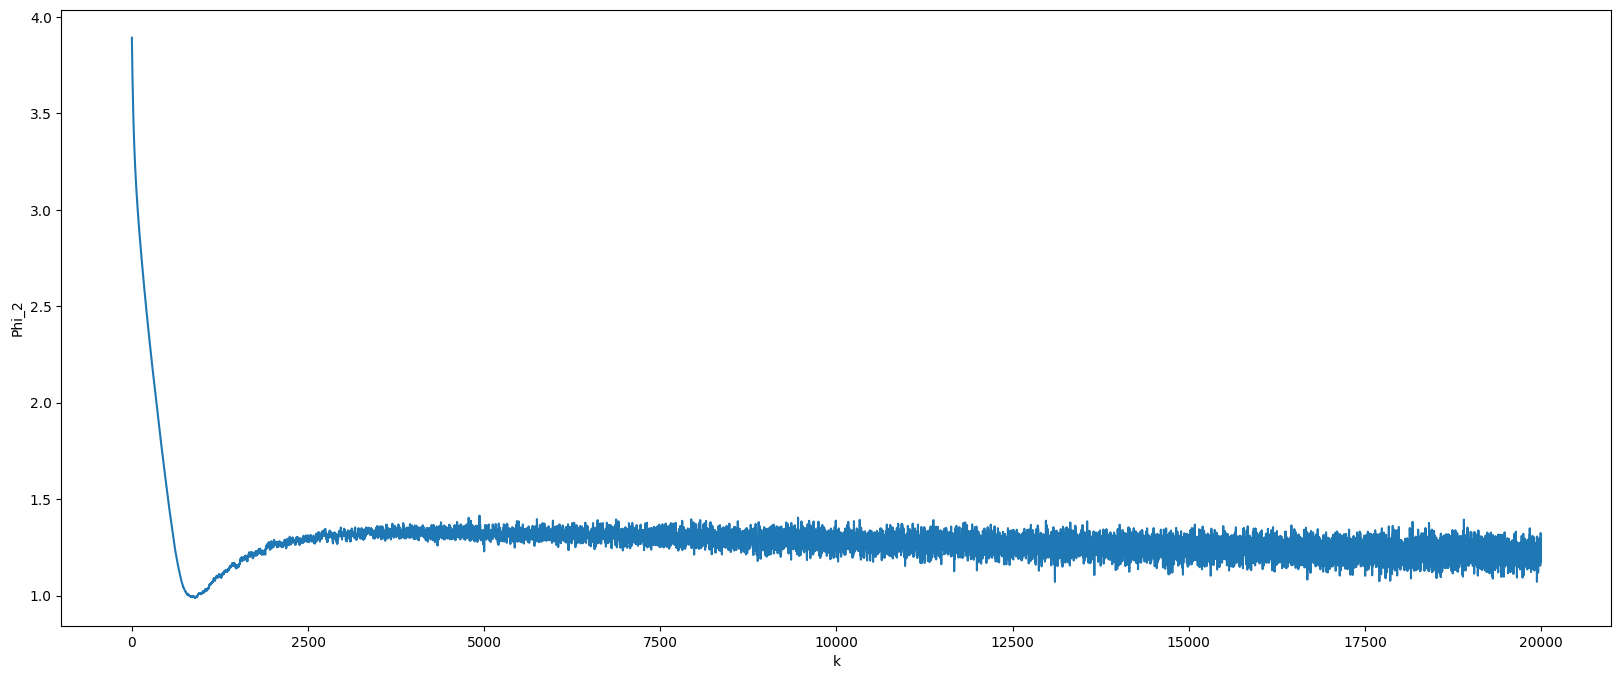

In [17]:
plt.figure(figsize=(20,8))
plt.plot(results["phi2"])
plt.xlabel("k")
plt.ylabel("Phi_2")
plt.show()

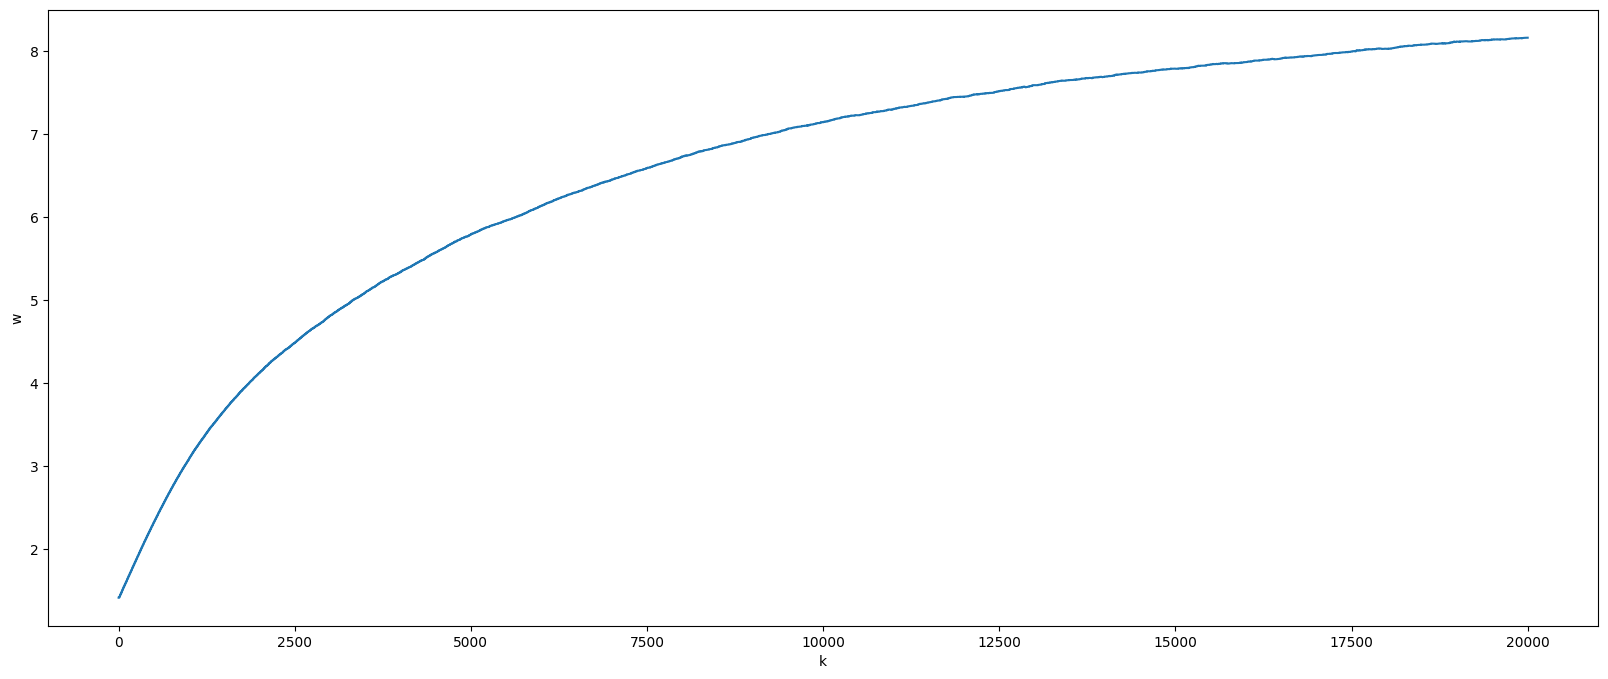

In [18]:
plt.figure(figsize=(20,8))
plt.plot(results["w"])
plt.xlabel("k")
plt.ylabel("w")
plt.show()

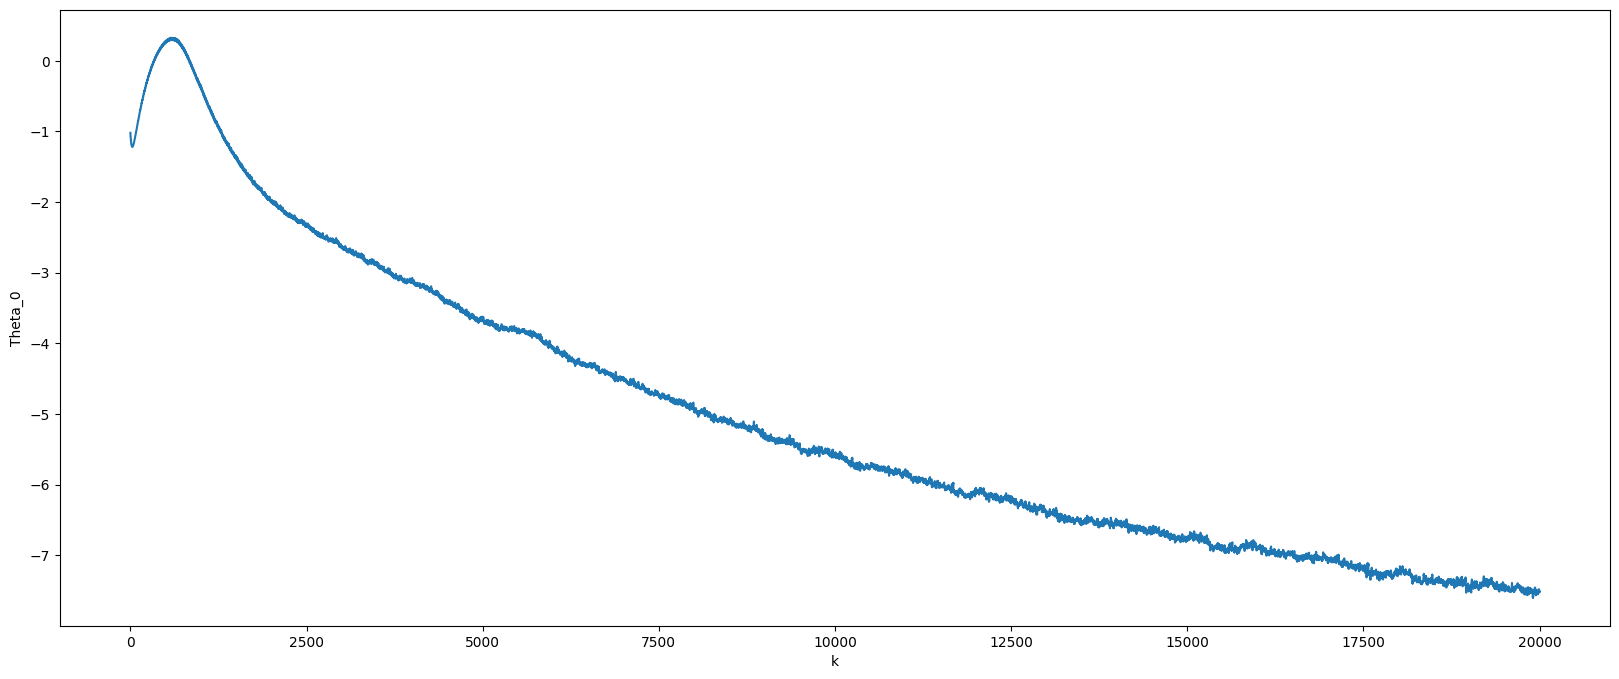

In [19]:
plt.figure(figsize=(20,8))
plt.plot(results["theta0"])
plt.xlabel("k")
plt.ylabel("Theta_0")
plt.show()

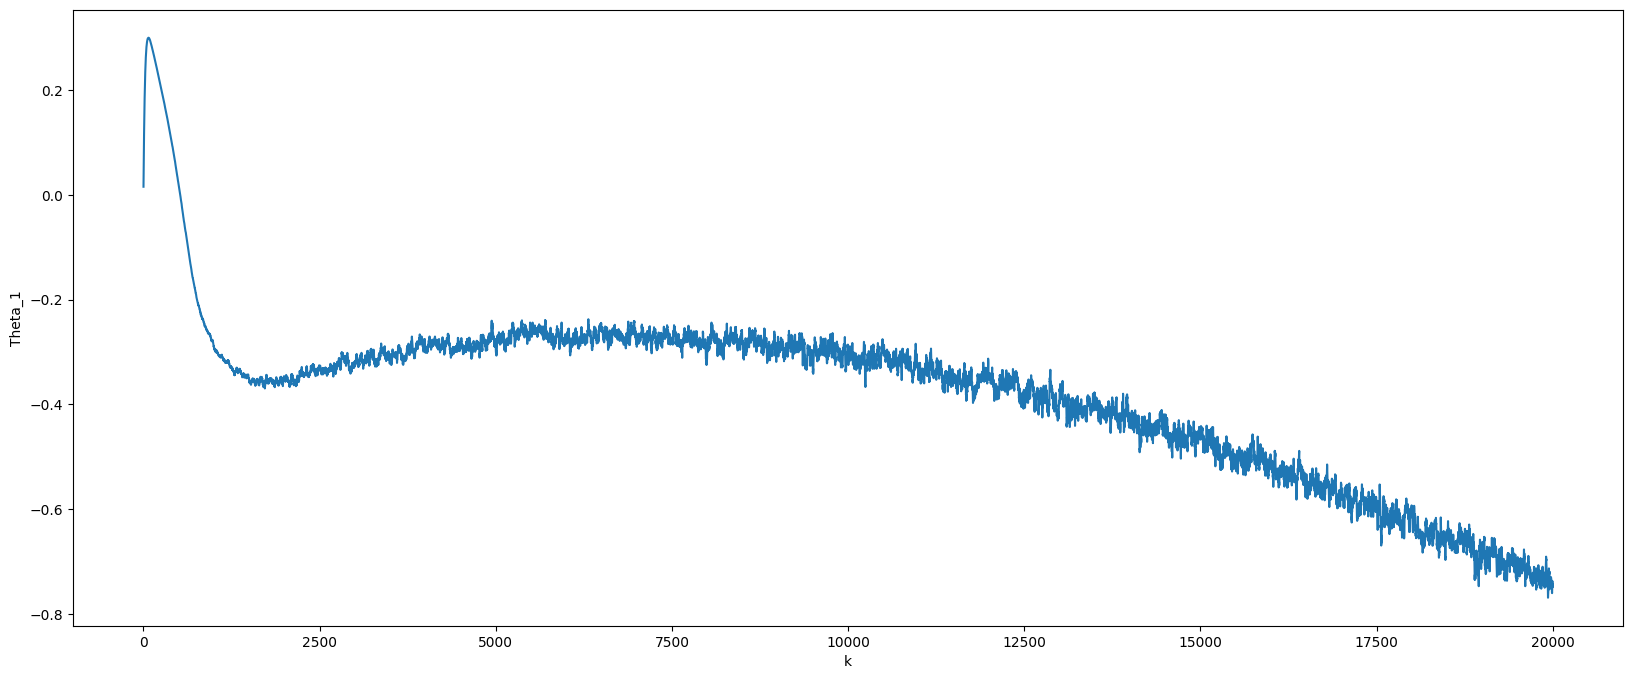

In [20]:
plt.figure(figsize=(20,8))
plt.plot(results["theta1"])
plt.xlabel("k")
plt.ylabel("Theta_1")
plt.show()

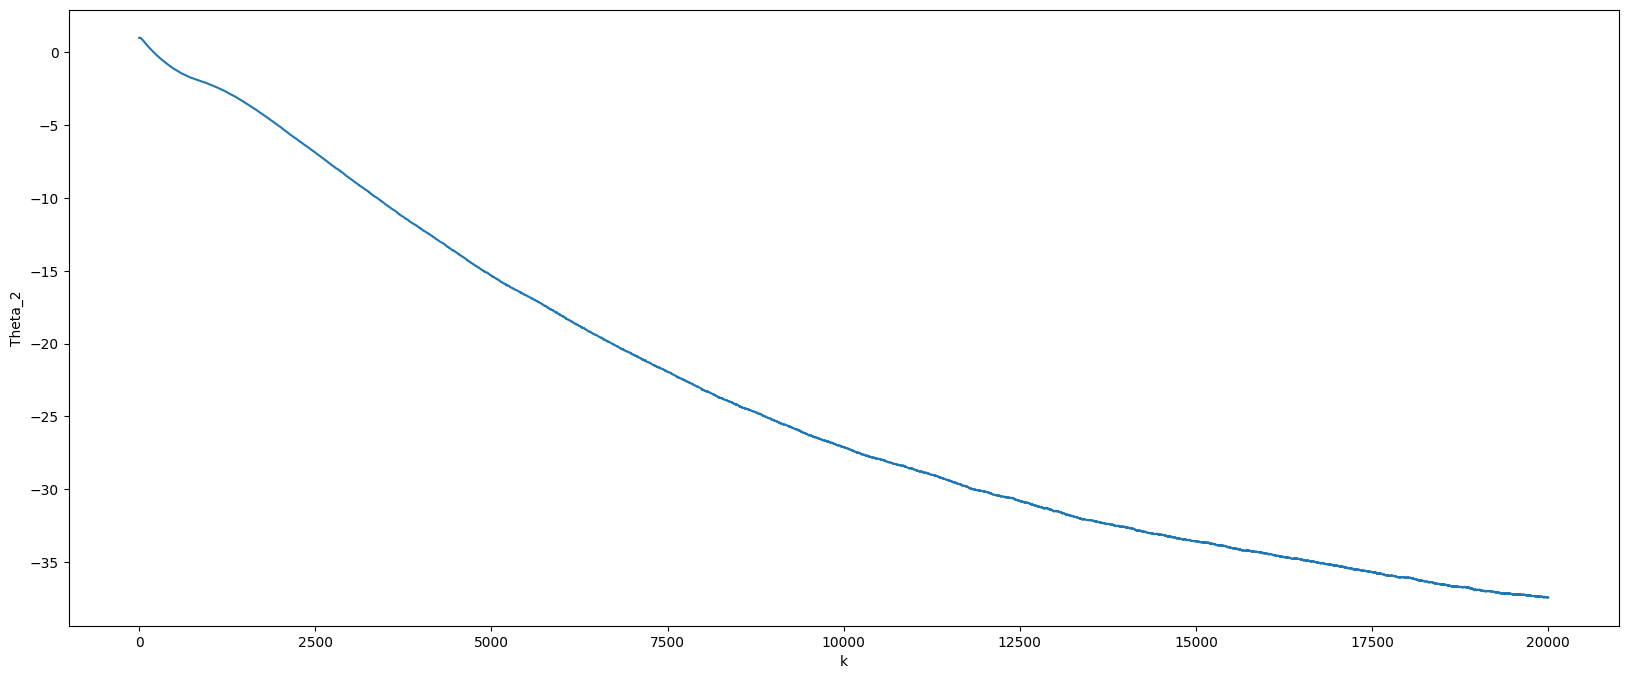

In [21]:
plt.figure(figsize=(20,8))
plt.plot(results["theta2"])
plt.xlabel("k")
plt.ylabel("Theta_2")
plt.show()

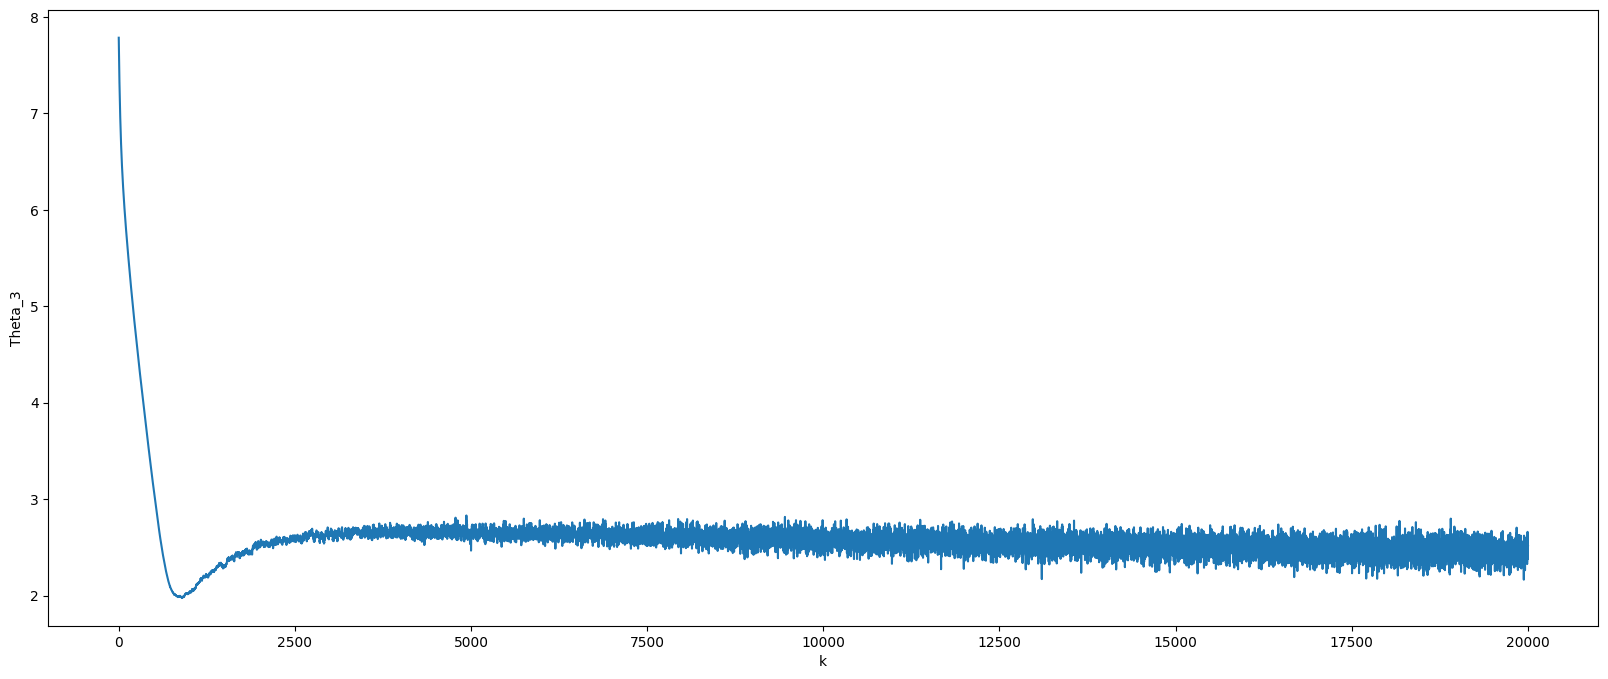

In [22]:
plt.figure(figsize=(20,8))
plt.plot(results["theta3"])
plt.xlabel("k")
plt.ylabel("Theta_3")
plt.show()

#### Some doubts on decaying lambda formula

With formula in the paper:
$$\lambda_k = \lambda_0 \left( 1 - \exp\left(\frac{200(k - M)}{M}\right) \right)$$

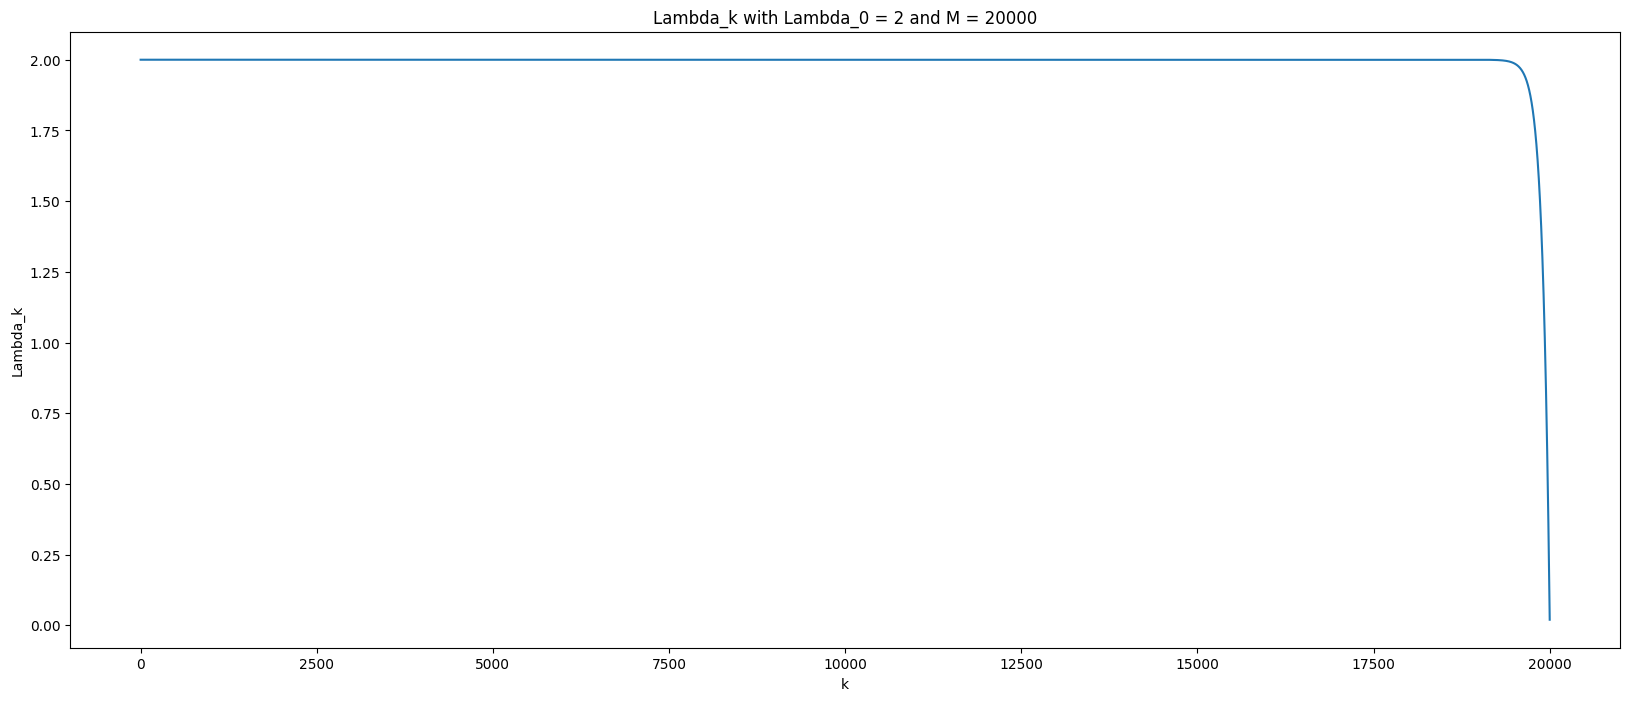

In [23]:
l0 = 2
M = 20000
k = np.array([i for i in range(M)])

lk = l0*(1 - np.exp(200*(k-M)/M))
plt.figure(figsize=(20,8))
plt.plot(lk)
plt.xlabel("k")
plt.ylabel("Lambda_k")
plt.title("Lambda_k with Lambda_0 = 2 and M = 20000")
plt.show()

With this formula:
$$\lambda_k = \lambda_0 \left( 1 - \exp\left(\frac{(k - M)}{M}\right) \right)$$

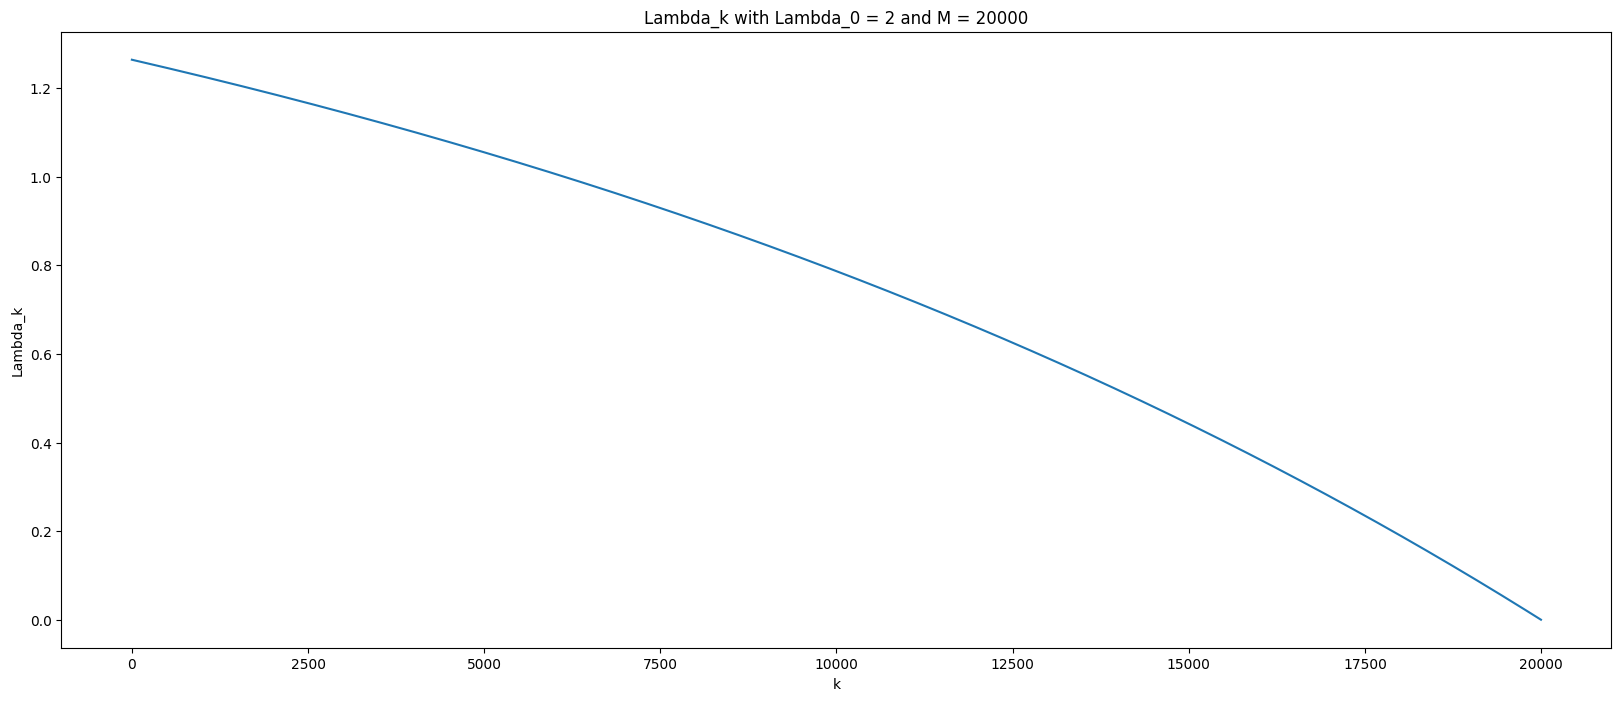

In [24]:
l0 = 2
M = 20000
k = np.array([i for i in range(M)])

lk = l0*(1 - np.exp((k-M)/M))
plt.figure(figsize=(20,8))
plt.plot(lk)
plt.xlabel("k")
plt.ylabel("Lambda_k")
plt.title("Lambda_k with Lambda_0 = 2 and M = 20000")
plt.show()